In [ ]:
!pip install flask
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
!pip install face_recognition


In [46]:
!pip install DetrForObjectDetection



ERROR: Could not find a version that satisfies the requirement DetrForObjectDetection (from versions: none)
ERROR: No matching distribution found for DetrForObjectDetection


In [ ]:
!pip install deepface

In [ ]:
!pip install pyngrok flask_ngrok


In [ ]:
!ngrok authtoken 2ds6zFTVi4QpC30RSOgbyj6cJtN_4NGgfZ8fpQydd385bpqzs

We will start by getting the network and unzipping it

In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# Set paths
drive_path = '/mydrive/ClaritaHAWAT_LU_WebDev/'
zip_file = 'darknet.zip'

In [ ]:
destination_folder = '/content/'
%cd ..
# Copy zip file from Google Drive to Colab
!cp -r "{drive_path}" "{destination_folder}"

In [ ]:
!unzip -q "/content/ClaritaHAWAT_LU_WebDev/darknet.zip" -d '/content/'

# Now we Need to Actually Run The **code**

In [ ]:
!mkdir /content/Test

In [ ]:
DATABASE_PATH = r"/content/ClaritaHAWAT_LU_WebDev/Database"
darknet_path = 'darknet'
config_path = 'darknet/cfg/yolov3_custom.cfg'
weights_path = '/content/ClaritaHAWAT_LU_WebDev/yolov3_custom_final.weights'
names_path = 'data/obj.names'
data_path = 'data/obj.data'

In [ ]:
from datetime import datetime

In [ ]:
#!"C:\Program Files (x86)\GnuWin32\bin\make.exe"
import matplotlib
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file
def download(path):
  from google.colab import files
  files.download(path)



Deep Face Algo to recgnize Faces

In [61]:
from deepface import DeepFace
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
def recognize_familiar_face(image_path):
    image = Image.open(image_path)
    imes = image_path
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    isPerson = False
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
                f"Detected {model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"

        )
        if model.config.id2label[label.item()] == 'person':
                      isPerson = True
    if not isPerson:
         return 'No Person Detected'
    print('here 1')
    # Load known face encodings and names (from your dataset)
    known_face_encodings = []  # List of known face encodings
    known_face_names = []  # List of corresponding person names

    confidence_threshold = 0.2  # Adjust as needed

    # Iterate through your dataset and populate the lists
    for person_folder in os.listdir(DATABASE_PATH):
        person_path = os.path.join(DATABASE_PATH, person_folder)
        print('here 2')
        if os.path.isdir(person_path):
            images = [f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            for image in images:
                image_path = os.path.join(person_path, image)
                face_image = face_recognition.load_image_file(image_path)

                # Assume there's only one face per image for simplicity
                face_encodings = face_recognition.face_encodings(face_image)

                if face_encodings:
                    known_face_encodings.append(face_encodings[0])
                    known_face_names.append(person_folder)
                # Append the encoding and corresponding name to the lists
                # known_face_encodings.append(face_encoding)
                # known_face_names.append(person_folder)

    # Load an unknown image for face recognition
    #unknown_image_path = r'C:\Users\Pc\Desktop\CH\Lebanese University\M2\AI Python\Grumpy\Test\einstein.jpeg'
    unknown_image = face_recognition.load_image_file(image_path)
    print('here 3 ')
    # Find face locations and encode faces in the unknown image
    face_locations = face_recognition.face_locations(unknown_image)
    face_encodings = face_recognition.face_encodings(unknown_image, face_locations)

    # Compare faces in the unknown image with known faces
    # Change this part of the code
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # Check if the face matches any known face
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.6)

        confidence = 0.0
        print('here 4')

        # If a match is found, use the name of the known face

        if any(matches):
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            confidence = 1.0 - face_distances[first_match_index]
            similarity_score = 1 / (1 + face_distances[first_match_index])  # Reciprocal transformation
        if confidence >= confidence_threshold:
            label = f"{name}: {confidence:.2%}"

        else:
            label = "Unknown Person"

        # Print the name and draw a rectangle around the face in the image

        cv2.rectangle(unknown_image, (left, top), (right, bottom), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(unknown_image, label, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)
    dfs = DeepFace.find(img_path = image_path, db_path = DATABASE_PATH)
    print("dfs" + str(dfs))
    # To
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # Check if any face matches any known face
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.6)
        confidence = 0.0

        print('here 5')
        # If a match is found, use the name of the known face with the highest confidence
        if any(matches):
            max_confidence_index = matches.index(True)
            for i in range(len(matches)):
                if matches[i] and face_distances[i] > confidence:
                    max_confidence_index = i
                    confidence = face_distances[i]
                    print("conf is " + str(confidence))
            name = known_face_names[max_confidence_index]
            similarity_score = 1 / (1 + confidence)  # Reciprocal transformation
        print("conf is " + str(confidence))
        if confidence >= confidence_threshold:
            label = f"{name}: {confidence:.2%}"
            return label
        else:
            label = "No Face Detected"
            try:
              print(imes)
              image = Image.open(imes)
              objs = DeepFace.analyze(img_path = np.array(image), actions = ['age', 'gender', 'race', 'emotion'])
              print(str(objs))
              age = objs[0]['age']
              dominant_gender = objs[0]['dominant_gender']
              dominant_emotion = objs[0]['dominant_emotion']

              return f' Age detected is {age}, gender {dominant_gender} and They seem {dominant_emotion}'
            except Exception as e:
              print(e)
              return label


        # directory_path = '/content/Original Images/'
        # if not os.path.exists(directory_path):
        #     os.makedirs(directory_path)

        # Print the name and draw a rectangle around the face in the image

        cv2.rectangle(unknown_image, (left, top), (right, bottom), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(unknown_image, label, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)

    # Display the result
    # cv2.imshow('Face Recognition Result', cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR))

    cv2_imshow(cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR))

    cv2.waitKey(0)
    cv2.destroyAllWindows()

Now to handle saving to Database

In [ ]:
def SaveToDB(file,name):
    os.makedirs(f'{DATABASE_PATH}/{name}')
    current_datetime = datetime.now()
    # Format the date and time as a string
    formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H:%M:%S")
    try:
        cv2.imwrite(f'{DATABASE_PATH}/{name}/{name}-{formatted_datetime}.jpg', unknown_image)
    except Exception as e:
        print("Error saving image:", str(e))

Here we handle the object detection, classes are = handgun, shotgun and Knife

In [ ]:
import shutil

def detect_image(image):
    !ls
    temp_dir = "/content/Test"
    current_datetime = datetime.now()
    %cd ../..

    formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H:%M:%S")
    os.makedirs(temp_dir, exist_ok=True)
    name = f'Upload-{formatted_datetime}.jpg'
    # Save the image to a temporary file
    temp_file_path = os.path.join(temp_dir, f"{name}")
    image.save(temp_file_path)

    #image.save(os.path.join(app.config["UPLOAD_FOLDER"], name))
    #file_path = os.path.join(app.config['UPLOAD_FOLDER'], name)
    os.chdir("content/darknet/")
    command = f"./darknet detector test data/obj.data cfg/yolov3_custom.cfg {weights_path} {temp_file_path} -thresh 0.3 --out '/content/ClaritaHAWAT_LU_WebDev/static/predictions.jpg'"
    source_file = '/content/darknet/predictions.jpg'
    destination_file = '/content/ClaritaHAWAT_LU_WebDev/static/predictions.jpg'

    # Copy the file


    output = subprocess.check_output(command, shell=True)
    shutil.copyfile(source_file, destination_file)
    imShow('predictions.jpg')
    # Get the last line of the output which contains the predicted class
    shutil.copyfile(source_file, destination_file)

    return '../darknet/predictions.jpg'
    print("predicted class" + predicted_class)
    os.chdir("../..")
    # if predicted_class: return predicted_class
    # else: return 'No Object Detected'
    # Here I should return good image




Now Flask To handle routing

In [ ]:
!ls -l /usr/local/bin/ngrok
!chmod +x /usr/local/bin/ngrok

In [62]:

import subprocess
ngrok_process = subprocess.Popen(["ngrok", "http", "5000"])


#command = ["ngrok", "http", "-host-header=rewrite", "127.0.0.1:5000"]
#command = ["ngrok", "http", "https://localhost:5000", "--host-header=rewrite"]

#ngrok_process = subprocess.Popen(command)
#!ngrok http 5000 --log=stdout &
#!ngrok http 5000 --log=stdout &

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
/
index.html
/content/ClaritaHAWAT_LU_WebDev/Templates
main
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://98f4-34-168-150-233.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:52:19] "GET / HTTP/1.1" 200 -


index


INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:52:20] "GET /favicon.ico HTTP/1.1" 404 -


image yayyyyy
image yayyyyy
trying to detect
bin			    datalab  kaggle  libx32   NGC-DL-CONTAINER-LICENSE	run   tmp
boot			    dev      lib     media    opt			sbin  tools
content			    etc      lib32   mnt      proc			srv   usr
cuda-keyring_1.0-1_all.deb  home     lib64   mydrive  root			sys   var
/


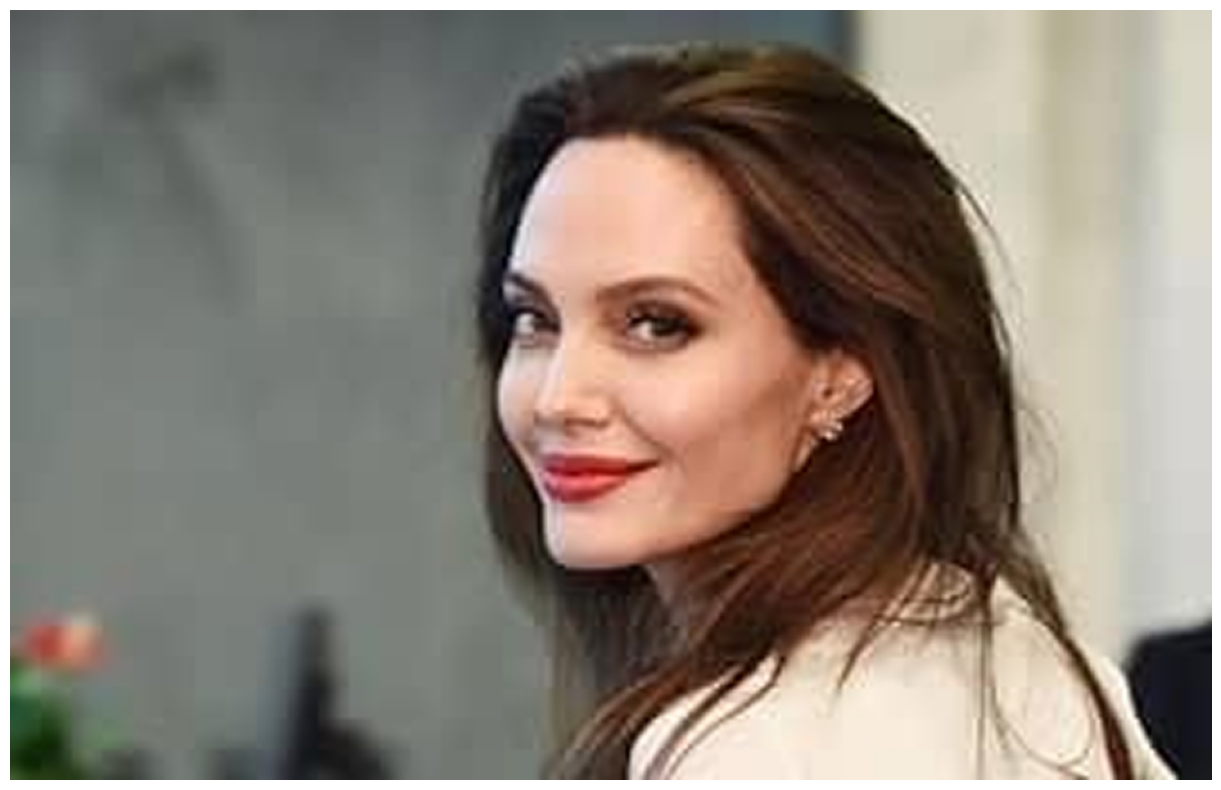

Detected person with confidence 0.907 at location [116.92, 7.69, 310.92, 200.03]
here 1
here 2
here 2
here 2
here 2
here 2
here 3 
here 4
24-03-19 14:52:52 - Searching /content/ClaritaHAWAT_LU_WebDev/Database/Brad Pitt/Brad Pitt_0.jpg in 13 length datastore
24-03-19 14:52:53 - find function duration 0.32078003883361816 seconds
dfs[                                            identity  \
0  /content/ClaritaHAWAT_LU_WebDev/Database/Brad ...   

                                       hash  target_x  target_y  target_w  \
0  098be12fcd71e1f83ad998a473ddb05ccbf73fd4       353        63       365   

   target_h  source_x  source_y  source_w  source_h  threshold      distance  
0       365       353        63       365       365       0.68  1.110223e-16  ]
here 5
conf is 0.0
<FileStorage: 'Angelina_Jolie2.jpg' ('image/jpeg')>


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]
INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:52:53] "POST /upload_image HTTP/1.1" 200 -


[{'age': 28, 'region': {'x': 104, 'y': 41, 'w': 105, 'h': 105, 'left_eye': (31, 39), 'right_eye': (63, 41)}, 'face_confidence': 0.92, 'gender': {'Woman': 100.0, 'Man': 4.31351701024596e-06}, 'dominant_gender': 'Woman', 'race': {'asian': 0.05490760086104274, 'indian': 0.4223874304443598, 'black': 0.005912886626902036, 'white': 69.55764889717102, 'middle eastern': 16.890990734100342, 'latino hispanic': 13.068157434463501}, 'dominant_race': 'white', 'emotion': {'angry': 6.473307306853471e-09, 'disgust': 3.1425405416612274e-15, 'fear': 1.258303865562995e-13, 'happy': 99.98795986175537, 'sad': 9.792927579965749e-08, 'surprise': 6.00121555639592e-12, 'neutral': 0.012039703142363578}, 'dominant_emotion': 'happy'}]
 Age detected is 28, gender Woman and They seem happy
trying to reply to client


INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:52:54] "GET /static/predictions.jpg HTTP/1.1" 200 -


image yayyyyy
image yayyyyy
trying to detect
3rdparty	DarknetConfig.cmake.in	generate_train.py      net_cam_v4.sh	vcpkg.json
backup		darknet_images.py	image_yolov3.sh        obj		vcpkg.json.opencv23
build		darknet.py		image_yolov4.sh        package.xml	video_yolov3.sh
build.ps1	darknet_video.py	include		       predictions.jpg	video_yolov4.sh
cfg		data			json_mjpeg_streams.sh  README.md
cmake		docker-compose.yml	LICENSE		       results
CMakeLists.txt	Dockerfile.cpu		Makefile	       scripts
darknet		Dockerfile.gpu		net_cam_v3.sh	       src
/


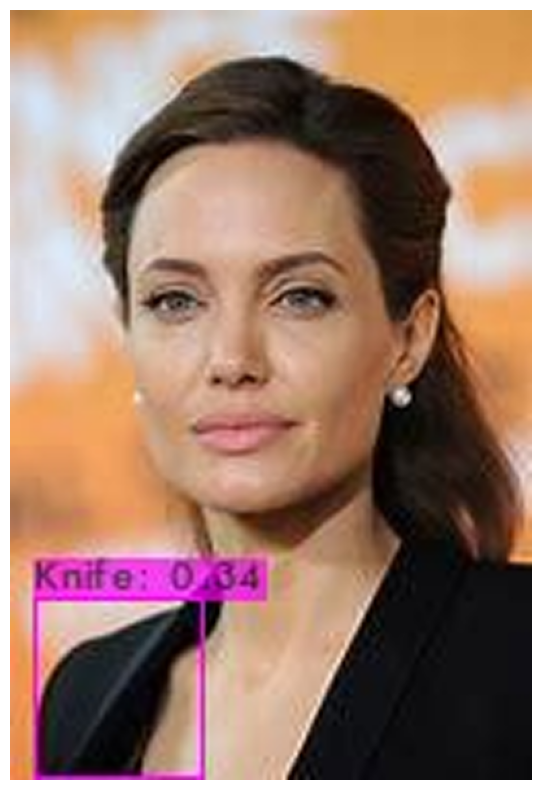

Detected tie with confidence 0.97 at location [7.46, 144.43, 53.81, 197.83]
Detected person with confidence 0.998 at location [-0.03, 10.27, 133.96, 197.92]
here 1
here 2
here 2
here 2
here 2
here 2
here 3 
here 4
24-03-19 14:53:31 - Searching /content/ClaritaHAWAT_LU_WebDev/Database/Brad Pitt/Brad Pitt_0.jpg in 13 length datastore
24-03-19 14:53:32 - find function duration 0.33683109283447266 seconds
dfs[                                            identity  \
0  /content/ClaritaHAWAT_LU_WebDev/Database/Brad ...   

                                       hash  target_x  target_y  target_w  \
0  098be12fcd71e1f83ad998a473ddb05ccbf73fd4       353        63       365   

   target_h  source_x  source_y  source_w  source_h  threshold      distance  
0       365       353        63       365       365       0.68  1.110223e-16  ]
here 5
conf is 0.0
<FileStorage: 'Angelina_Jolie.jpg' ('image/jpeg')>


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]
INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:53:32] "POST /upload_image HTTP/1.1" 200 -


[{'age': 32, 'region': {'x': 16, 'y': 39, 'w': 85, 'h': 85, 'left_eye': (26, 35), 'right_eye': (59, 35)}, 'face_confidence': 0.9, 'gender': {'Woman': 99.99992847442627, 'Man': 7.023403441053233e-05}, 'dominant_gender': 'Woman', 'race': {'asian': 6.384496771365212, 'indian': 2.38868105493075, 'black': 1.1619573220287158, 'white': 41.0284513848097, 'middle eastern': 10.594838744094297, 'latino hispanic': 38.44157686481338}, 'dominant_race': 'white', 'emotion': {'angry': 0.769985094666481, 'disgust': 0.00032169259611691814, 'fear': 6.151877343654633, 'happy': 0.5792513955384493, 'sad': 6.53265193104744, 'surprise': 0.018703188106883317, 'neutral': 85.94721555709839}, 'dominant_emotion': 'neutral'}]
 Age detected is 32, gender Woman and They seem neutral
trying to reply to client
image yayyyyy
image yayyyyy
trying to detect
3rdparty	DarknetConfig.cmake.in	generate_train.py      net_cam_v4.sh	vcpkg.json
backup		darknet_images.py	image_yolov3.sh        obj		vcpkg.json.opencv23
build		darknet

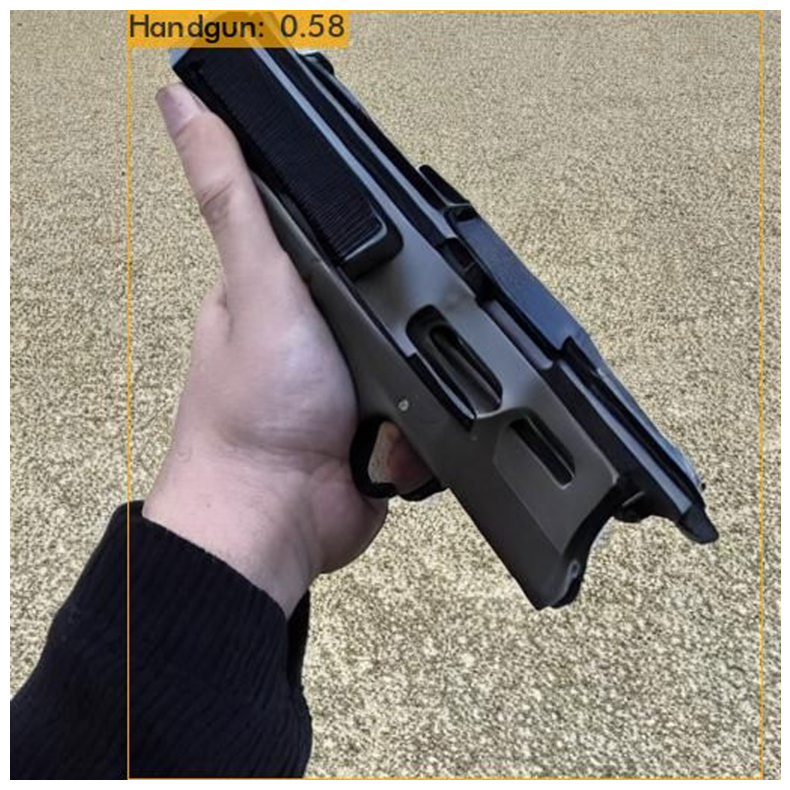

Detected person with confidence 0.996 at location [0.41, 45.95, 284.29, 508.75]
here 1
here 2
here 2
here 2
here 2
here 2
here 3 
here 4
24-03-19 14:55:22 - Searching /content/ClaritaHAWAT_LU_WebDev/Database/Brad Pitt/Brad Pitt_0.jpg in 13 length datastore
24-03-19 14:55:22 - find function duration 0.5428659915924072 seconds
dfs[                                            identity  \
0  /content/ClaritaHAWAT_LU_WebDev/Database/Brad ...   

                                       hash  target_x  target_y  target_w  \
0  098be12fcd71e1f83ad998a473ddb05ccbf73fd4       353        63       365   

   target_h  source_x  source_y  source_w  source_h  threshold      distance  
0       365       353        63       365       365       0.68  1.110223e-16  ]
here 5
conf is 0.0
<FileStorage: 'Test_handgun.jpg' ('image/jpeg')>


INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:55:23] "POST /upload_image HTTP/1.1" 200 -


Face could not be detected in numpy array.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
No Face Detected
trying to reply to client


INFO:werkzeug:127.0.0.1 - - [19/Mar/2024 14:55:47] "GET /static/predictions.jpg HTTP/1.1" 200 -


image yayyyyy
image yayyyyy
trying to detect
3rdparty	DarknetConfig.cmake.in	generate_train.py      net_cam_v4.sh	vcpkg.json
backup		darknet_images.py	image_yolov3.sh        obj		vcpkg.json.opencv23
build		darknet.py		image_yolov4.sh        package.xml	video_yolov3.sh
build.ps1	darknet_video.py	include		       predictions.jpg	video_yolov4.sh
cfg		data			json_mjpeg_streams.sh  README.md
cmake		docker-compose.yml	LICENSE		       results
CMakeLists.txt	Dockerfile.cpu		Makefile	       scripts
darknet		Dockerfile.gpu		net_cam_v3.sh	       src
/


In [63]:
from flask import Flask, render_template, request, jsonify,url_for
import os
import face_recognition
from pyngrok import ngrok
!ngrok authtoken 2ds6zFTVi4QpC30RSOgbyj6cJtN_4NGgfZ8fpQydd385bpqzs
from flask_ngrok import run_with_ngrok

from io import BytesIO
import cv2
from PIL import Image


%cd ../..
!ls /content/ClaritaHAWAT_LU_WebDev/Templates

template_folder=os.path.abspath('/content/ClaritaHAWAT_LU_WebDev/Templates')
static_folder=os.path.abspath('/content/ClaritaHAWAT_LU_WebDev/static')

print(template_folder)
app = Flask(__name__,template_folder=template_folder,
            static_folder=static_folder)

run_with_ngrok(app)

@app.route('/')
def index():
    print("index")
    return render_template('index.html')

@app.route('/send_message', methods=['POST'])
def send_message():
    user_message = request.form['user_message']
    # Here you can process the user's message and generate a response
    # For simplicity, let's just echo the user's message
    bot_response = user_message
    print('text yayyyyy')
    return jsonify({'bot_response': bot_response})


@app.route('/upload_image', methods=['POST'])
def upload_image():
    print('image yayyyyy')
    #user_message = request.form['user_message']
    # Here you can process the user's message and generate a response
    # For simplicity, let's just echo the user's message

    if 'image' in request.files:
        img_file = request.files['image']
        if img_file.filename != '':
            print('image yayyyyy')
            img_bytes = img_file.read()
            img = Image.open(BytesIO(img_bytes))
            # Process the image (optional)
            # img = process_image(img)
            img_bytes_io = BytesIO()
            img.save(img_bytes_io, format='JPEG')  # Save image data to BytesIO
            img_bytes_io.seek(0)  # Rewind BytesIO to the beginning
            # return img_bytes_io.getvalue(), 200, {'Content-Type': 'image/jpeg'}  # Return image data as response

            print('trying to detect')
            detected_object = detect_image(img)

            img_reco = recognize_familiar_face(img_file)
            #img_reco = "clari this is static"
            print(img_reco)
            print('trying to reply to client')
            #predictions_image_url = url_for('darknet', filename='predictions.jpg')
            return jsonify({'bot_response': img_reco, 'bot_image' : detected_object})
            #return jsonify({'bot_response': img_reco})
    print('fi shi ghalat yayyyyy')
    bot_response = 'rcv out';
    return jsonify({'bot_response': bot_response})


@app.route('/save_to_db', methods=['POST'])
def save_to_db():
    print('here')
    response = request.json['response']
    print('rs^p given is ' + response)

    name = request.json['name']
    print('name^p given is ' + name)

    file = request.files['file']
    print('file given is ' + str(file))
    # Check if the file is present
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request'}), 400

    # Check if the file has a filename
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    if response.lower() == 'yes' and name and file:
        # Here you can save the image to the database with the provided name
        # For simplicity, let's just return a success message
        try:
            SaveToDB(file=file,name=name)
        except Exception as e:

            return jsonify({'bot_response': 'Invalid request'}), 400

        return jsonify({'bot_response': f'Image saved to database with name: {name}'}), 200
    else:
        # If the response is not 'yes' or if no name is provided, return an error message
        return jsonify({'bot_response': 'Invalid request'}), 400




if __name__ == '__main__':
    #dataset = fiftyone.zoo.load_zoo_dataset("coco-2017")
    print("main")
    #app.run(debug=True)
    app.config["UPLOAD_FOLDER"] = "/content/Test"

    app.run()

    #threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()



In [ ]:
!ls